### Description

- Tâche: Analyse de sentiment
- Labels: 1, 2, 3, 4, 5
- Données: Avis sur Amazon
- Langue: français

Pour récupérer les données :

```bash
aws s3 cp s3://amazon-reviews-ml/json/train/dataset_fr_train.json . --no-sign-request
aws s3 cp s3://amazon-reviews-ml/json/test/dataset_fr_test.json . --no-sign-request
aws s3 cp s3://amazon-reviews-ml/json/dev/dataset_fr_dev.json . --no-sign-request
```


dataset | 1 | 2 | 3 | 4 | 5 | total
- | - | - | - | - | - | -
train | 40000 | 40000 | 40000 | 40000 | 40000 | 200000
dev | 1000 | 1000 | 1000 | 1000 | 1000 | 5000
test | 1000 | 1000 | 1000 | 1000 | 1000 | 5000

## Read data

In [4]:
import json
import os
import pandas as pd
from sklearn.utils import shuffle
from collections import Counter
from pprint import pprint
from datetime import datetime
import yaml
import pickle
import numpy as np


directory = '../dataset'
train_path = directory + os.sep + 'dataset_fr_train.json'
dev_path = directory + os.sep + 'dataset_fr_dev.json'
test_path = directory + os.sep + 'dataset_fr_test.json'

In [18]:
def load_data(path, size_por_class=None, replace_labels=None, random=True, random_state=42):
    
    # 0. read file
    with open(path, 'r', encoding='utf8') as data_stream:
        data = [json.loads(line) for line in data_stream]
    df = pd.DataFrame(data)
    df = df.astype({'stars': int})
    
    # 1. replace labels if required
    if replace_labels is not None:
        df = df.replace({'stars': replace_labels})
    
    # 2. filtering if required
    if type(size_por_class) is int:
        keep = []
        for key, df_class in df.groupby(['stars']):
            samples = df_class.sample(size_por_class, random_state=random_state)
            keep.append(samples)
        df = pd.concat(keep)
    
    if type(size_por_class) is dict:
        keep = []
        for key, df_class in df.groupby(['stars']):
            if key in size_por_class:
                samples = df_class.sample(size_por_class[key], random_state=random_state)
                keep.append(samples)
        df = pd.concat(keep)
    
    
    # 3. shuffling if required
    if shuffle:
        df = shuffle(df, random_state=random_state)
        
    X = df['review_body'].values
    y = df['stars'].values
    return X, y



def save(
    model, report, model_name, directory='ml_models'
):
    time = datetime.now()
    time = time.strftime("%Y%m%d-%H%M%S")
    
    dir_name = f"{model_name}-{time}"
    dir_path = f"{directory}{os.sep}{dir_name}"
    os.mkdir(dir_path)
    
    model_config = model.get_params(deep=False)
    config_path = f"{dir_path}{os.sep}config.yml"
    with open(config_path, "w") as stream_file:
        yaml.dump(model_config, stream_file)

    report_path = f"{dir_path}{os.sep}report.txt"
    with open(report_path, "w") as stream_file:
        stream_file.write(report)

    model_path = f"{dir_path}{os.sep}model.pkl"
    with open(model_path, "wb") as stream_file:
        pickle.dump(model, stream_file)


## Strategy: Train SVM model regression

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from math import floor, ceil

In [433]:


clf = Pipeline([
    ('vect',
         FeatureUnion([
             ('vect_1', TfidfVectorizer(
                analyzer='word',
                token_pattern=r'(?u)\b\w+\b',
                lowercase=True,
                # max_features=10000,
                ngram_range=(1, 3))),
         ])
    ),  
    ('svm',
        SVR(
            kernel='linear', 
            C=1,
        )),
    ])



X_train, y_train = load_data(
    train_path, 
    size_por_class=1000,
)
X_dev, y_dev = load_data(
    dev_path,
    size_por_class=1000,
)

# print(Counter(y_train))
# print(Counter(y_dev))

weights = {
    1: 1, 2: 3, 3: 3, 4: 3, 5: 1
}
sample_weight = [weights[y] for y in y_train]
clf.fit(X_train, y_train, svm__sample_weight=sample_weight)
y_pred = clf.predict(X_dev)

mse = mean_squared_error(y_dev, y_pred)
print('MSE : ', mse)

MSE :  0.9429449294353573


[3.47040851 4.11824956 3.4404143  ... 2.40691393 3.42955999 2.3329304 ]
              precision    recall  f1-score   support

           1       0.68      0.32      0.44      1000
           2       0.37      0.47      0.41      1000
           3       0.31      0.49      0.38      1000
           4       0.38      0.48      0.43      1000
           5       0.59      0.26      0.37      1000

    accuracy                           0.41      5000
   macro avg       0.47      0.41      0.41      5000
weighted avg       0.47      0.41      0.41      5000



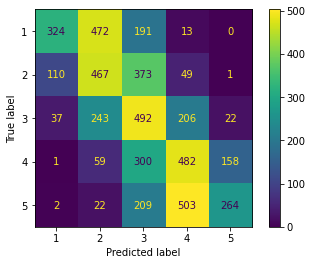

In [436]:
print(y_pred)

def get_label(pred):
    if pred < 1:
        return 1
    if pred > 1 and pred < 2:
        return round(pred)
    if pred > 2 and pred < 4:
        return round(pred)
    if pred > 4 and pred < 5:
        return round(pred)
    if pred > 5:
        return 5

y_pred_c = [get_label(pred) for pred in y_pred]

report = classification_report(y_dev, y_pred_c)
print(report)

cm = confusion_matrix(y_dev, y_pred_c, labels=[1, 2, 3, 4, 5])
dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
dist.plot()

## Strategy: Train SVM model classification one-vs-rest

Counter({2: 1000, 3: 1000, 1: 1000, 4: 1000, 5: 1000})
Counter({2: 1000, 3: 1000, 1: 1000, 4: 1000, 5: 1000})
              precision    recall  f1-score   support

           1       0.61      0.59      0.60      1000
           2       0.39      0.41      0.40      1000
           3       0.36      0.39      0.37      1000
           4       0.38      0.38      0.38      1000
           5       0.59      0.53      0.56      1000

    accuracy                           0.46      5000
   macro avg       0.47      0.46      0.46      5000
weighted avg       0.47      0.46      0.46      5000



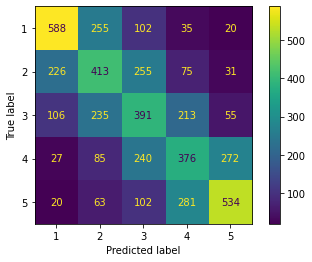

In [437]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


clf = Pipeline([
    ('vect',
         FeatureUnion([
             ('vect_1', TfidfVectorizer(
                analyzer='word',
                token_pattern=r'(?u)\b\w+\b',
                lowercase=True,
                # max_features=10000,
                ngram_range=(1, 3))),
         ])
    ),  
    ('svm',
        LinearSVC(
            # kernel='linear', 
            C=1,
            # decision_function_shape='ovo'
            # probability=True,
            class_weight={2: 3, 3: 5, 4: 3}
            # class_weight={1: 3, 5: 3}
        )),
    ])


X_train, y_train = load_data(
    train_path, 
    size_por_class=1000
    # size_por_class={'3': 1000, '4': 1000},
)
X_dev, y_dev = load_data(
    dev_path,
    size_por_class=1000
    # size_por_class={'3': 1000, '4': 1000},
)

print(Counter(y_train))
print(Counter(y_dev))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
report = classification_report(y_dev, y_pred)
print(report)

cm = confusion_matrix(y_dev, y_pred, labels=clf.classes_)
dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
dist.plot()

save(clf, report, 'one-vs-rest', directory='../ml_models')

## Test with grouped class

              precision    recall  f1-score   support

           1       0.85      0.89      0.87      1000
           5       0.88      0.84      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



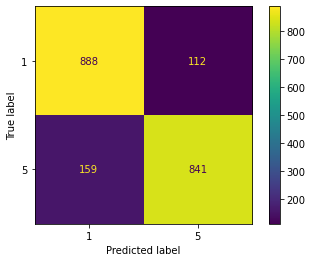

In [30]:
clf = Pipeline([
    ('vect',
         FeatureUnion([
             ('vect_1', TfidfVectorizer(
                analyzer='word',
                token_pattern=r'(?u)\b\w+\b',
                lowercase=True,
                # max_features=10000,
                ngram_range=(1, 3))),
         ])
    ),  
    ('svm',
        LinearSVC(
            # kernel='linear', 
            C=1,
            # decision_function_shape='ovo'
            # probability=True,
            # class_weight={2: 3, 3: 5, 4: 3}
            # class_weight={1: 3, 5: 3}
        )),
    ])


replace_labels = {2: 1, 4: 5}
size_por_class={1: 1000, 5: 1000}
# size_por_class=1000

X_train, y_train = load_data(
    train_path,
    replace_labels=replace_labels,
    size_por_class=size_por_class,
)
X_dev, y_dev = load_data(
    dev_path,
    replace_labels=replace_labels,
    size_por_class=size_por_class,
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
report = classification_report(y_dev, y_pred)
print(report)

cm = confusion_matrix(y_dev, y_pred, labels=clf.classes_)
dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
dist.plot()

# save(clf, report, 'one-vs-rest', directory='../ml_models')